In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import PowerTransformer, LabelEncoder

In [2]:
df = pd.read_csv("March_2024_AF2_01.txt", sep=r"\s+", header=None)
df.columns = ['Protein_number', 'res_number', 'PB1', 'PB2', 'AA1', 'AA2', 'S2_1', 'S2_2', 'expected_frequency', 'plDDT', 'RSA1', 'RSA2']
df

,Protein_number,res_number,PB1,PB2,AA1,AA2,S2_1,S2_2,expected_frequency,plDDT,RSA1,RSA2
0,0,7,j,j,G,G,C,S,0.880055,60.180000,100.000000,100.000000
1,1,95,n,l,E,Q,T,T,0.736402,96.220001,89.762611,98.582039
2,1,219,i,d,G,N,S,C,0.040571,31.870001,100.000000,100.000000
3,1,222,d,i,T,V,C,C,0.021758,47.259998,100.000000,100.000000
4,1,223,i,d,V,P,C,C,0.040571,38.200001,100.000000,93.366096
...,...,...,...,...,...,...,...,...,...,...,...,...
671150,23508,14909273,j,d,G,L,C,C,0.623739,95.459999,1.531394,20.793951
671151,23508,14909291,f,d,C,D,P,S,0.047665,95.379997,11.473963,100.000000
671152,23508,14909390,j,d,G,P,S,P,0.623739,80.699997,65.849922,88.452087
671153,23508,14909434,g,f,L,T,C,C,0.430306,79.760002,60.491493,46.452702


In [3]:
numerical_cols = ['expected_frequency', 'plDDT', 'RSA1', 'RSA2']
categorical_cols = ['PB1', 'PB2', 'AA1', 'AA2', 'S2_1', 'S2_2']

## Visualization using UMAP

In [4]:
df_umap = df.copy() # creating a copy for visualization purposes

In [5]:
# Numerical data is transformed using Yeo-Johnson transformation 
# to stabilize variance and make data more closely resemble a normal distribution

pt = PowerTransformer(method='yeo-johnson')
df_umap[numerical_cols] = pt.fit_transform(df_umap[numerical_cols])

# Categorical data is transformed using Label Encoding
for cat_col in categorical_cols:
    le = LabelEncoder()
    df_umap[cat_col] = le.fit_transform(df_umap[cat_col])

# sample data and combining transformed categorical and numerical columns
df_umap_sample = df_umap.sample(frac=0.1, random_state=42)
df_umap = df_umap_sample[numerical_cols + categorical_cols].to_numpy()

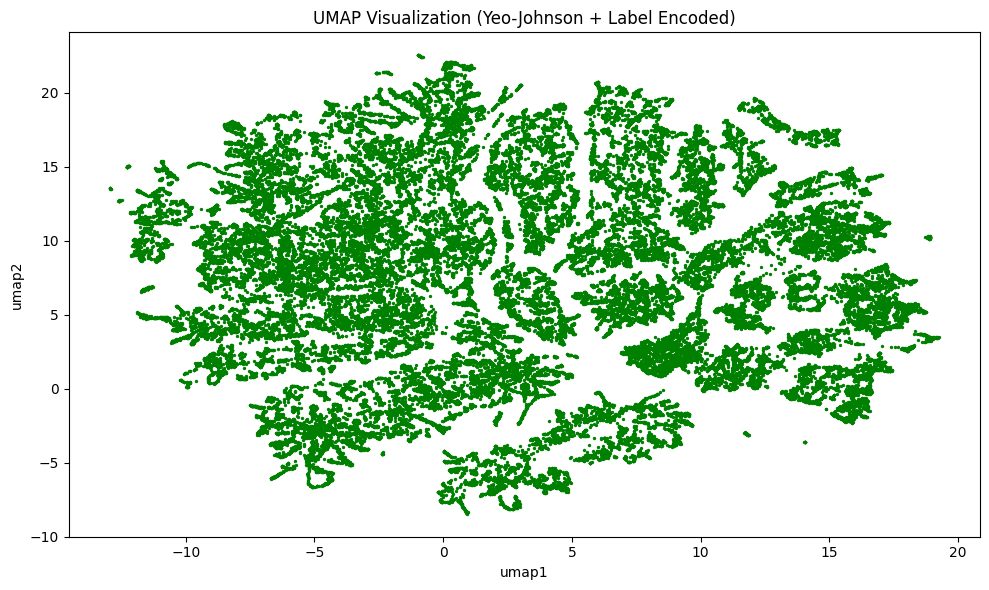

In [6]:
umap = umap.UMAP(n_components=2, n_neighbors=10, min_dist=0.3)
embedding = umap.fit_transform(df_umap)

plt.figure(figsize=(10, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], s=2, alpha=1.0, c='green')
plt.title('UMAP Visualization (Yeo-Johnson + Label Encoded)')
plt.xlabel('umap1')
plt.ylabel('umap2')
plt.tight_layout()
plt.show()

#### The UMAP 2D visualization reveals a non-random structure, with noticeable local groupings of data points.  
#### This suggests that the dataset contains underlying patterns that may be captured through clustering in the full feature space, even though the visualization was generated from sampled data.

## K-Prototypes clustering

In [14]:
# for k-prototypes categorical data doesn’t need any pre-processing, we only need array with indices of categorical columns
# for numerical data Yeo-Johnson transform is applied.
kprot_df = df.copy()

pt = PowerTransformer(method='yeo-johnson')
kprot_df[numerical_cols] = pt.fit_transform(kprot_df[numerical_cols])

categorical_cols_indices = [kprot_df.columns.get_loc(col) for col in categorical_cols]
print(categorical_cols_indices)

[2, 3, 4, 5, 6, 7]


In [ ]:
from kmodes.kprototypes import KPrototypes
# range for number of clusters is based on UMAP visualization 
# the best number is going to be determined with elbow method
costs = []
clusters_assigned = []
for i in range(5, 15):
    try:
        kproto = KPrototypes(n_clusters= i, init='Cao', verbose=2)
        clusters = kproto.fit_predict(kprot_df.to_numpy(), categorical=categorical_cols_indices)
        costs.append(kproto.cost_)
        clusters_assigned.append(clusters)
    except:
        print(f"Can't cluster with {i} clusters")

In [ ]:
# elbow method
plt.figure(figsize=(10, 5))
plt.plot(ks, costs, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Elbow method')
plt.show()

In [ ]:
final_k = 10 # obtainted via elbow method


## HDBSCAN + Gower distance 